# LSTM on the true data

Dans ce notebook, nous allons appliquer l'architecture finale du notebook précédent sur les données traitées dans le notebook 1.

## Import des données prétraitées

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
data_folder = "../input/"
df = pd.read_csv(data_folder + "train_processed.csv", index_col=0)
df.head(100)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40,2376.5800,2399.5000,2357.1400,2374.5900,19.233006,2373.116500,-0.004218
1,1514764860,0,5,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062500,-0.014643
3,1514764860,5,32,7.6596,7.6596,7.6567,7.6576,6626.713400,7.657713,-0.013922
4,1514764860,7,5,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264
...,...,...,...,...,...,...,...,...,...,...
95,1514765520,11,8,327.6700,327.6800,326.7700,326.7700,17.901632,326.990480,0.000000
96,1514765580,2,38,2366.8333,2398.2000,2340.6000,2365.3767,8.981063,2364.424800,-0.000176
97,1514765580,0,24,8.3991,8.4559,8.3573,8.4200,604.390000,8.413630,-0.007573
98,1514765580,1,257,13690.7900,13900.0000,13473.4700,13696.6380,21.794142,13691.957000,-0.003605


In [3]:
df_btc = df[df["Asset_ID"] == 1]
df_btc.drop(columns=['Asset_ID'])
df = df[1:1]
del df
df_btc.head(100)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
2,1514764860,1,229,13835.194,14013.8,13666.11,13850.176,31.550062,13827.0625,-0.014643
10,1514764920,1,235,13835.036,14052.3,13680.00,13828.102,31.046432,13840.3620,-0.015037
18,1514764980,1,528,13823.900,14000.4,13601.00,13801.314,55.061820,13806.0680,-0.010309
26,1514765040,1,435,13802.512,13999.0,13576.28,13768.040,38.780530,13783.5980,-0.008999
34,1514765100,1,742,13766.000,13955.9,13554.44,13724.914,108.501640,13735.5870,-0.008079
...,...,...,...,...,...,...,...,...,...,...
734,1514770560,1,251,13578.452,13716.2,13477.20,13583.102,21.376007,13575.9810,-0.010156
742,1514770620,1,164,13575.430,13652.0,13480.05,13573.494,19.540440,13571.5060,-0.011496
750,1514770680,1,155,13570.390,13650.5,13491.53,13576.724,24.406158,13571.0890,-0.011092
758,1514770740,1,155,13575.892,13650.4,13515.89,13566.432,23.870950,13568.3750,-0.013064


## Génération du modèle

In [4]:
def plot_series(time, series, format="-", start=0, end=None, ratio=None):
    """Simply plot the Serie"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if ratio is not None:
        plt.axvline(x=int(len(time) * (1 - ratio)))
    plt.grid(True)

def split(time, serie, ratio=0.3):
    """Splits the dataset into (1 - ratio) training and (ratio) validation"""
    assert len(serie) == len(time), "Time and Serie size don't fit"
    assert 0 < ratio and ratio < 1, "Ratio should be between 0 and 1"
    split_time = math.ceil(len(time) * (1 - ratio))
    time_train, x_train = time[:split_time], series[:split_time]
    time_valid, x_valid = time[split_time:], series[split_time:]
    return time_train, x_train, time_valid, x_valid

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def modelGenerator():    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.LSTM(100, return_sequences=True),
        tf.keras.layers.LSTM(100),
        tf.keras.layers.Dense(100),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])
    return model

def historyGenerator(x_train, window_size, batch_size):
    # clear the previous session
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)
    # call the model generator
    model = modelGenerator()
    # prepare the dataset
    train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=1000)
    # create the callback
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**((epoch + 50) / 20))
    # set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
    # compile the model
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    # run the training
    history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
    return history

def learningRateGenerator(history, margin=0.005):
    """Use the callback to test different learning rates and choose the best one"""
    # find the best learning rate
    y = np.array(history.history["loss"])
    eps = (max(y) - min(y)) * margin
    y = (y[:-1] - y[1:]) < - eps
    x = history.history["lr"][:-1]
    x0 = np.extract(y, x)[0]
    # plot the graph to check that everything is okais
    plt.title("Loss according to the learning rate")
    plt.semilogx(history.history["lr"], history.history["loss"])
    plt.axvline(x=x0)
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    return x0

def train(x_train, x_valid, window_size, batch_size, learning_rate, epochs):
    """Train the model with the best learning rate"""
    # clear the previous session
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)
    # call the model generator
    model = modelGenerator()
    # prepare the dataset
    train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=1000)
    val_set = windowed_dataset(x_valid, window_size, batch_size=batch_size, shuffle_buffer=1000)
    # set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    # compile the model
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    # run the training
    history = model.fit(train_set, validation_data=val_set, epochs=epochs)
    return model, history

def plotHistory(history):
    """Plot the training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Training History')
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Loss (0 - 100%)')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='upper left')
    
    start = int(len(history.history['loss']) / 2)
    ax2.plot(history.history['loss'][start:])
    ax2.plot(history.history['val_loss'][start:])
    ax2.set_title('Loss (50 - 100 %)')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    
def forecast(model, series, window_size, split_time):
    """Use the model to forecast on the valid set"""
    forecast=[]
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results

In [5]:
modelGenerator().summary()

2022-02-04 14:42:28.533176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 14:42:28.599229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 14:42:28.599412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 14:42:28.600970: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          128       
                                                                 
 lstm (LSTM)                 (None, None, 100)         53200     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 lambda_1 (Lambda)           (None, 100)               0         
                                                                 
Total params: 143,828
Trainable params: 143,828
Non-trai

1000 values


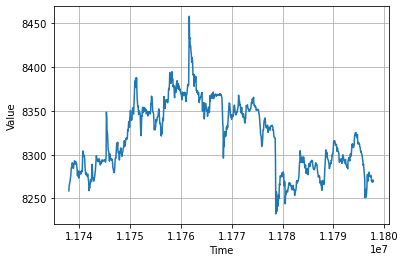

In [6]:
series = df_btc['VWAP']
time = df_btc['timestamp'] - 1514764860
start = int(len(series) * 0.1)
end = start + 1000
series = series[start:end].to_numpy()
time = time[start:end].to_numpy()
print(end - start, "values")

# Split
ratio = 0.3
time_train, x_train, time_valid, x_valid = split(time, series, ratio)

# Plot
plot_series(time, series)

# Parameters to learn
window_size = 60
batch_size = 90

In [7]:
history_lr = historyGenerator(x_train, window_size, batch_size)

Epoch 1/100


2022-02-04 14:42:35.209183: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301


8/8 [==============================] - 7s 56ms/step - loss: 8339.8037 - mae: 8340.3037 - lr: 3.1623e-06
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 8339.1914 - mae: 8339.6914 - lr: 3.5481e-06
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 8338.4727 - mae: 8338.9727 - lr: 3.9811e-06
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 8337.5801 - mae: 8338.0801 - lr: 4.4668e-06
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 8336.5576 - mae: 8337.0566 - lr: 5.0119e-06
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 8335.4297 - mae: 8335.9297 - lr: 5.6234e-06
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 8334.2051 - mae: 8334.7051 - lr: 6.3096e-06
Epoch 8/100
8/8 [==============================] - 0s 16ms/step - loss: 8332.8691 - mae: 8333.3691 - lr: 7.0795e-06
Epoch 9/100
8/8 [==============================] - 0s 15ms/step - loss: 8331.4180 - 

8/8 [==============================] - 0s 11ms/step - loss: 38.8588 - mae: 39.3564 - lr: 0.0112
Epoch 73/100
8/8 [==============================] - 0s 12ms/step - loss: 46.9476 - mae: 47.4452 - lr: 0.0126
Epoch 74/100
8/8 [==============================] - 0s 13ms/step - loss: 69.0934 - mae: 69.5920 - lr: 0.0141
Epoch 75/100
8/8 [==============================] - 0s 11ms/step - loss: 84.1243 - mae: 84.6234 - lr: 0.0158
Epoch 76/100
8/8 [==============================] - 0s 11ms/step - loss: 101.7022 - mae: 102.2013 - lr: 0.0178
Epoch 77/100
8/8 [==============================] - 0s 11ms/step - loss: 119.5536 - mae: 120.0529 - lr: 0.0200
Epoch 78/100
8/8 [==============================] - 0s 11ms/step - loss: 136.1989 - mae: 136.6982 - lr: 0.0224
Epoch 79/100
8/8 [==============================] - 0s 11ms/step - loss: 148.9751 - mae: 149.4746 - lr: 0.0251
Epoch 80/100
8/8 [==============================] - 0s 13ms/step - loss: 162.8435 - mae: 163.3430 - lr: 0.0282
Epoch 81/100
8/8 [====

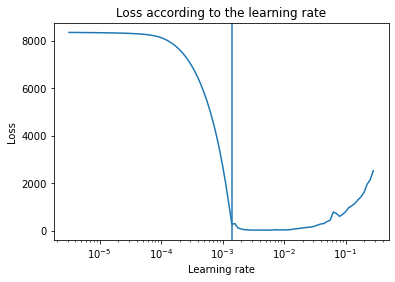

In [8]:
lr = learningRateGenerator(history_lr, margin=0.00000001)

In [9]:
model, history = train(x_train, x_valid, window_size, batch_size, lr, epochs=400)

Epoch 1/400
8/8 [==============================] - 6s 411ms/step - loss: 8323.3516 - mae: 8323.8516 - val_loss: 8234.2441 - val_mae: 8234.7451
Epoch 2/400
8/8 [==============================] - 0s 53ms/step - loss: 8217.5898 - mae: 8218.0898 - val_loss: 7988.7676 - val_mae: 7989.2676
Epoch 3/400
8/8 [==============================] - 0s 34ms/step - loss: 7827.5884 - mae: 7828.0884 - val_loss: 7374.1016 - val_mae: 7374.6016
Epoch 4/400
8/8 [==============================] - 0s 40ms/step - loss: 7109.7124 - mae: 7110.2124 - val_loss: 6513.0415 - val_mae: 6513.5415
Epoch 5/400
8/8 [==============================] - 0s 39ms/step - loss: 6183.1133 - mae: 6183.6133 - val_loss: 5501.7827 - val_mae: 5502.2827
Epoch 6/400
8/8 [==============================] - 0s 39ms/step - loss: 5139.2446 - mae: 5139.7446 - val_loss: 4417.9238 - val_mae: 4418.4238
Epoch 7/400
8/8 [==============================] - 0s 45ms/step - loss: 4040.6226 - mae: 4041.1226 - val_loss: 3301.5146 - val_mae: 3302.0146
Epoch

8/8 [==============================] - 0s 28ms/step - loss: 27.2412 - mae: 27.7395 - val_loss: 39.7111 - val_mae: 40.2111
Epoch 62/400
8/8 [==============================] - 0s 24ms/step - loss: 27.9952 - mae: 28.4890 - val_loss: 50.0323 - val_mae: 50.5323
Epoch 63/400
8/8 [==============================] - 0s 23ms/step - loss: 26.4838 - mae: 26.9781 - val_loss: 53.4029 - val_mae: 53.9029
Epoch 64/400
8/8 [==============================] - 0s 23ms/step - loss: 26.3062 - mae: 26.7993 - val_loss: 51.7504 - val_mae: 52.2504
Epoch 65/400
8/8 [==============================] - 0s 24ms/step - loss: 26.3236 - mae: 26.8174 - val_loss: 51.2825 - val_mae: 51.7825
Epoch 66/400
8/8 [==============================] - 0s 24ms/step - loss: 26.1880 - mae: 26.6804 - val_loss: 52.9497 - val_mae: 53.4497
Epoch 67/400
8/8 [==============================] - 0s 23ms/step - loss: 26.2575 - mae: 26.7515 - val_loss: 45.3098 - val_mae: 45.8098
Epoch 68/400
8/8 [==============================] - 0s 25ms/step - l

8/8 [==============================] - 0s 25ms/step - loss: 26.1465 - mae: 26.6393 - val_loss: 57.0567 - val_mae: 57.5567
Epoch 122/400
8/8 [==============================] - 0s 44ms/step - loss: 26.1469 - mae: 26.6404 - val_loss: 54.9288 - val_mae: 55.4288
Epoch 123/400
8/8 [==============================] - 0s 27ms/step - loss: 26.3303 - mae: 26.8239 - val_loss: 56.6339 - val_mae: 57.1339
Epoch 124/400
8/8 [==============================] - 0s 24ms/step - loss: 26.3590 - mae: 26.8525 - val_loss: 57.6437 - val_mae: 58.1437
Epoch 125/400
8/8 [==============================] - 0s 23ms/step - loss: 26.8469 - mae: 27.3399 - val_loss: 54.4584 - val_mae: 54.9584
Epoch 126/400
8/8 [==============================] - 0s 25ms/step - loss: 27.1009 - mae: 27.5982 - val_loss: 59.2302 - val_mae: 59.7302
Epoch 127/400
8/8 [==============================] - 0s 23ms/step - loss: 27.1300 - mae: 27.6259 - val_loss: 50.4761 - val_mae: 50.9761
Epoch 128/400
8/8 [==============================] - 0s 23ms/s

8/8 [==============================] - 0s 32ms/step - loss: 27.8139 - mae: 28.3101 - val_loss: 59.9019 - val_mae: 60.4019
Epoch 182/400
8/8 [==============================] - 0s 28ms/step - loss: 27.4968 - mae: 27.9912 - val_loss: 41.2607 - val_mae: 41.7607
Epoch 183/400
8/8 [==============================] - 0s 26ms/step - loss: 27.2572 - mae: 27.7518 - val_loss: 42.9440 - val_mae: 43.4440
Epoch 184/400
8/8 [==============================] - 0s 25ms/step - loss: 27.4696 - mae: 27.9662 - val_loss: 54.4431 - val_mae: 54.9431
Epoch 185/400
8/8 [==============================] - 0s 25ms/step - loss: 26.6328 - mae: 27.1266 - val_loss: 53.8404 - val_mae: 54.3404
Epoch 186/400
8/8 [==============================] - 0s 23ms/step - loss: 26.5926 - mae: 27.0871 - val_loss: 61.0576 - val_mae: 61.5576
Epoch 187/400
8/8 [==============================] - 0s 25ms/step - loss: 26.4530 - mae: 26.9495 - val_loss: 53.3452 - val_mae: 53.8452
Epoch 188/400
8/8 [==============================] - 0s 32ms/s

8/8 [==============================] - 0s 22ms/step - loss: 29.2831 - mae: 29.7798 - val_loss: 72.6251 - val_mae: 73.1251
Epoch 242/400
8/8 [==============================] - 0s 22ms/step - loss: 28.7894 - mae: 29.2871 - val_loss: 57.7560 - val_mae: 58.2560
Epoch 243/400
8/8 [==============================] - 0s 25ms/step - loss: 26.5546 - mae: 27.0484 - val_loss: 56.3293 - val_mae: 56.8293
Epoch 244/400
8/8 [==============================] - 0s 23ms/step - loss: 26.3636 - mae: 26.8573 - val_loss: 61.3869 - val_mae: 61.8869
Epoch 245/400
8/8 [==============================] - 0s 23ms/step - loss: 26.6715 - mae: 27.1654 - val_loss: 55.9139 - val_mae: 56.4139
Epoch 246/400
8/8 [==============================] - 0s 24ms/step - loss: 26.2221 - mae: 26.7112 - val_loss: 56.1325 - val_mae: 56.6325
Epoch 247/400
8/8 [==============================] - 0s 23ms/step - loss: 26.2200 - mae: 26.7139 - val_loss: 60.4315 - val_mae: 60.9315
Epoch 248/400
8/8 [==============================] - 0s 24ms/s

8/8 [==============================] - 0s 28ms/step - loss: 29.7312 - mae: 30.2261 - val_loss: 50.0088 - val_mae: 50.5088
Epoch 302/400
8/8 [==============================] - 0s 28ms/step - loss: 27.5178 - mae: 28.0139 - val_loss: 71.0506 - val_mae: 71.5506
Epoch 303/400
8/8 [==============================] - 0s 28ms/step - loss: 27.9800 - mae: 28.4780 - val_loss: 63.9660 - val_mae: 64.4660
Epoch 304/400
8/8 [==============================] - 0s 29ms/step - loss: 28.2346 - mae: 28.7306 - val_loss: 45.3649 - val_mae: 45.8649
Epoch 305/400
8/8 [==============================] - 0s 29ms/step - loss: 26.4072 - mae: 26.9015 - val_loss: 55.3855 - val_mae: 55.8855
Epoch 306/400
8/8 [==============================] - 0s 25ms/step - loss: 26.1307 - mae: 26.6235 - val_loss: 47.9809 - val_mae: 48.4809
Epoch 307/400
8/8 [==============================] - 0s 24ms/step - loss: 26.6814 - mae: 27.1758 - val_loss: 55.7244 - val_mae: 56.2244
Epoch 308/400
8/8 [==============================] - 0s 27ms/s

8/8 [==============================] - 0s 23ms/step - loss: 28.8139 - mae: 29.3087 - val_loss: 37.9616 - val_mae: 38.4616
Epoch 362/400
8/8 [==============================] - 0s 23ms/step - loss: 28.7238 - mae: 29.2187 - val_loss: 37.3499 - val_mae: 37.8499
Epoch 363/400
8/8 [==============================] - 0s 25ms/step - loss: 27.2704 - mae: 27.7662 - val_loss: 48.6491 - val_mae: 49.1491
Epoch 364/400
8/8 [==============================] - 0s 23ms/step - loss: 26.5640 - mae: 27.0611 - val_loss: 58.6595 - val_mae: 59.1595
Epoch 365/400
8/8 [==============================] - 0s 23ms/step - loss: 26.4456 - mae: 26.9407 - val_loss: 65.5050 - val_mae: 66.0050
Epoch 366/400
8/8 [==============================] - 0s 25ms/step - loss: 26.9410 - mae: 27.4371 - val_loss: 65.3991 - val_mae: 65.8991
Epoch 367/400
8/8 [==============================] - 0s 23ms/step - loss: 27.9546 - mae: 28.4511 - val_loss: 59.3826 - val_mae: 59.8826
Epoch 368/400
8/8 [==============================] - 0s 30ms/s

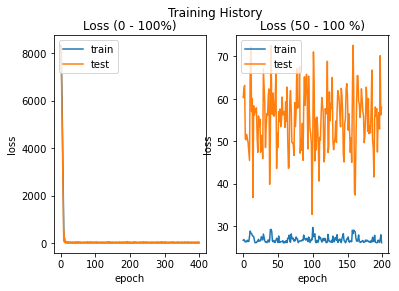

In [10]:
plotHistory(history)

In [11]:
# On fait la prédiction
split_time = math.ceil(len(time) * (1 - ratio))
results = forecast(model, series, window_size, split_time)

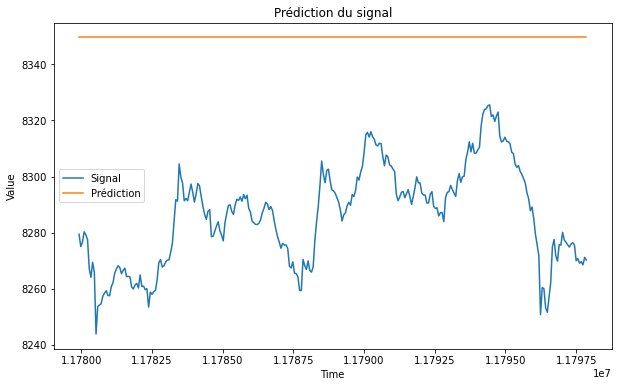

In [12]:
plt.figure(figsize=(10, 6))
plt.title("Prédiction du signal")
plt.plot(time_valid, x_valid, label="Signal")
plt.plot(time_valid, results, label="Prédiction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()